## Load Dataset

When working with Parallel Domain's synthetic data, the standard output format is [Dataset Governance Policy (DGP)](https://github.com/TRI-ML/dgp/blob/master/dgp/proto/README.md).
In general, the PD SDK can load from any format, as long as custom decoder exists adhering to the `DatasetDecoderProtocol`.
Out of the box, PD SDK comes with a pre-configured `DGPDatasetDecoder` which we can leverage to load data.

In this tutorial, we are going to load and access a dataset and its scenes.

Initially, we need to select the fitting decoder (in this case: `DGPDatasetDecoder`) and then tell it where our dataset is stored. The location can be either a local filesystem path or an s3 address.

In [1]:
from paralleldomain.decoding.dgp.decoder import DGPDatasetDecoder
from paralleldomain.model.dataset import Dataset  # optional import, just for type reference in this tutorial

dataset_path = "s3://pd-sdk-c6b4d2ea-0301-46c9-8b63-ef20c0d014e9/testset_dgp"
dgp_decoder = DGPDatasetDecoder(dataset_path=dataset_path)

dataset: Dataset = dgp_decoder.get_dataset()

Alternatively you can also use the decode_dataset helper method.

In [2]:
from paralleldomain.decoding.helper import decode_dataset
from paralleldomain.decoding.common import DecoderSettings

# To deactivate caching of certain data types use the DecoderSettings
settings = DecoderSettings(cache_images=False)
# decode dgp dataset
dgp_dataset: Dataset = decode_dataset(dataset_path=dataset_path, dataset_format="dgp", settings=settings)

If you want to load a dataset which is stored in Cityscapes or NuImages format simply change the dataset_format to "cityscapes" or "nuimages":

In [ ]:
nu_images_dataset_path = "some/path/to/a/nuimages/root/folder"
nu_images_dataset: Dataset = decode_dataset(dataset_path=nu_images_dataset_path, dataset_format="nuimages")

cityscapes_dataset_path = "some/path/to/a/cityscapes/root/folder"
cityscapes_dataset: Dataset = decode_dataset(dataset_path=nu_images_dataset_path, dataset_format="cityscapes")

### Dataset Information

Now that the dataset information has been loaded, we query a couple of metadata from it:

In [2]:
print("Dataset Metadata:")
print("Name:", dataset.metadata.name)
print("Available Annotation Types:", *[f"\t{a}" for a in dataset.available_annotation_types], sep="\n")
print("Custom Attributes:", *[f"\t{k}: {v}" for k,v in dataset.metadata.custom_attributes.items()], sep="\n")

Dataset Metadata:
Name: DefaultDatasetName
Available Annotation Types:
	<class 'paralleldomain.model.annotation.BoundingBoxes2D'>
	<class 'paralleldomain.model.annotation.BoundingBoxes3D'>
	<class 'paralleldomain.model.annotation.SemanticSegmentation2D'>
	<class 'paralleldomain.model.annotation.SemanticSegmentation3D'>
	<class 'paralleldomain.model.annotation.InstanceSegmentation2D'>
	<class 'paralleldomain.model.annotation.InstanceSegmentation3D'>
	<class 'paralleldomain.model.annotation.Depth'>
	<class 'paralleldomain.model.annotation.Annotation'>
	<class 'paralleldomain.model.annotation.Annotation'>
	<class 'paralleldomain.model.annotation.OpticalFlow'>
	<class 'paralleldomain.model.annotation.Annotation'>
Custom Attributes:
	origin: INTERNAL
	name: DefaultDatasetName
	creator: 
	available_annotation_types: [0, 1, 2, 3, 4, 5, 6, 10, 7, 8, 9]
	creation_date: 2021-06-22T15:16:21.317Z
	version: 
	description: 


As you can see, the property `.available_annotation_types` includes classes from `paralleldomain.model.annotation`. In tutorials around reading annotations from a dataset, these exact classes will be re-used, and allows for a consistent type-check across objects.

### Access available Scenes

Every dataset consists of scenes. These can contain ordered (usually: by time) or unordered data.
In this example, we are looking to receive a list of scene names by type that have been found within the loaded dataset.

In [3]:
for sn in dataset.scene_names:
    print(f"Found scene {sn}")

for usn in dataset.unordered_scene_names:
    print(f"Found unordered scene {usn}")

Found scene pd-sdk_test_set
Found unordered scene pd-sdk_test_set


## Load Scene

After having retrieved all scene names from a dataset, we get the actual `Scene` object and access a couple of properties as well as child objects.
Let's start with scene properties:


In [4]:
from paralleldomain.model.scene import Scene  # optional import, just for type reference in this tutorial
from pprint import PrettyPrinter


selected_scene = dataset.scene_names[0]  # for future
scene: Scene = dataset.get_scene(scene_name=selected_scene)

# Use prettyprint for nested dictionaries
pp = PrettyPrinter(indent=2)
pp.pprint(scene.metadata)

{ 'PD': { '@type': 'type.googleapis.com/dgp.proto.ParallelDomainSceneMetadata',
          'batch_id': 0,
          'cloud_cover': 0.10000000149011612,
          'fog_intensity': 0.0,
          'location': 'SF_6thAndMission_medium',
          'rain_intensity': 0.0,
          'region_type': 'NORTHERN_CALIFORNIA',
          'scene_type': 'URBAN',
          'street_lights': 0.0,
          'sun_azimuth': 0,
          'sun_elevation': 0,
          'time_of_day': 'LS_sky_noon_partlyCloudy_1113_HDS024',
          'version': 0,
          'wetness': 0}}


Scene metadata usually contains any variables that changes with each scene and are not necessarily consistent across a whole data.
In many cases these are environment variables like weather, time of day and location.

A `Scene` object also includes the information of the available annotation types. These be consistent in most datasets with the ones on the `Dataset` level, but there is the possibility to vary them.

In [5]:
pp.pprint(scene.available_annotation_types)

[ <class 'paralleldomain.model.annotation.BoundingBoxes2D'>,
  <class 'paralleldomain.model.annotation.BoundingBoxes3D'>,
  <class 'paralleldomain.model.annotation.SemanticSegmentation2D'>,
  <class 'paralleldomain.model.annotation.SemanticSegmentation3D'>,
  <class 'paralleldomain.model.annotation.InstanceSegmentation2D'>,
  <class 'paralleldomain.model.annotation.InstanceSegmentation3D'>,
  <class 'paralleldomain.model.annotation.Depth'>,
  <class 'paralleldomain.model.annotation.Annotation'>,
  <class 'paralleldomain.model.annotation.Annotation'>,
  <class 'paralleldomain.model.annotation.OpticalFlow'>,
  <class 'paralleldomain.model.annotation.Annotation'>]


Normally, in a scene, we expect to have more than one frame available, especially when we work with sequential data.
These can be accessed through their frame IDs. In DGP datasets, these are usually string representations of increasing integers, but they could be also more explicit identifiers for other datasets, e.g., a string representation of a UNIX time or recording vehicle details included.

In our example, the frame IDs follow the pattern of integers in string representation:

In [6]:
print(f"{scene.name} has {len(scene.frame_ids)} frames available.")
print(scene.frame_ids)

pd-sdk_test_set has 10 frames available.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Load Frame + Sensor

### Frames
A `Frame` object is like a timestamp-bracket around different sensor data. If we have multiple sensors mounted on our recording vehicle, then the single data recordings are usually grouped into specific timestamps.
We can retrieve a `Frame` object and actually see what the "grouping datetime" is:

In [7]:
frame_0_id = "0"
frame_0 = scene.get_frame(frame_id=frame_0_id)
print(frame_0.date_time)

2021-06-22 15:16:21.367000+00:00


Date/Times are presented as Python's std library `datetime` objects. When decoding data, the PD SDK also adds timezone information to these objects.

### Sensors

As a next step, we want to see what sensor are available within that scene. In general, sensors are divided into `CameraSensor` and `LidarSensor`.

In [8]:
print("Cameras:", *scene.camera_names, sep='\n')
print("\n")
print("LiDARs:", *scene.lidar_names, sep='\n')

Cameras:
camera_front
camera_rear
virtual_lidar_front_camera_0
virtual_lidar_front_camera_1
virtual_lidar_front_camera_2
virtual_lidar_rear_camera_0
virtual_lidar_rear_camera_1
virtual_lidar_rear_camera_2


LiDARs:
lidar_front
lidar_rear


Similar one how we used this information to get a scene from a dataset, we can use this to get a sensor from a scene.

In [9]:
camera_0_name = scene.camera_names[0]
camera_0 = scene.get_camera_sensor(camera_name=camera_0_name)

Knowing which frames and sensors are available allows us to now query for the actual sensor data.
As described above, a `Frame` is the time-grouping bracket around different sensor recordings. The actual data for a specific sensor assigned to this represented in a `SensorFrame`.
This is where sensor data and annotations live.

We can either first select a `Frame` and then pick a `Sensor` or the other way around. They will return the same `SensorFrame` instance.

In [10]:
camera_frame_via_frame = frame_0.get_camera(camera_name=camera_0_name)
camera_frame_via_camera = camera_0.get_frame(frame_id=frame_0_id)

assert(camera_frame_via_camera is camera_frame_via_camera)
print(f"Both objects are equal: {id(camera_frame_via_frame)} == {id(camera_frame_via_camera)}")

Both objects are equal: 140255650227008 == 140255650227008


## Load Sensor Frames

Now that we know how to retrieve `SensorFrame` object for specific sensors and timestamps, we can use those to extract the actual sensor data.

### Accessing shared properties
While there are `CameraSensorFrame` and `LidarSensorFrame` objects with sensor specific data, there are certain properties which are common to any `SensorFrame`.

We are going to print the most basic attributes on a `SensorFrame`, using the example of a `CameraSensorFrame` object.

In [11]:
# Get `CameraSensorFrame` for the first camera on the first frame within the scene.
lidar_0_name = scene.lidar_names[0]

camera_0_frame_0 = frame_0.get_camera(camera_name=camera_0_name)
lidar_0_frame_0 = frame_0.get_lidar(lidar_name=lidar_0_name)

print(f"{camera_0_frame_0.sensor_name} recorded at {camera_0_frame_0.date_time}")
print(f"{lidar_0_frame_0.sensor_name} recorded at {lidar_0_frame_0.date_time}")



camera_front recorded at 2021-06-22 15:16:21.367000+00:00
lidar_front recorded at 2021-06-22 15:16:21.367000+00:00


Every `SensorFrame` always has information about the sensor pose (where is it in the world coordinate system?) and sensor extrinsic (how is the sensor positioned relative to the ego-vehicle reference coordinate system=).
Poses and Extrinsics are represented as instances of the `Transformation` object. It allows storing 6-DoF information and allows for easy combination with each other.
In the example below, we are going to calculate the difference between the camera and the lidar sensor. The difference should be the same when using pose or extrinsic.

In [12]:
print(camera_0_frame_0.pose, " -> ", lidar_0_frame_0.pose)
camera_to_lidar_pose = camera_0_frame_0.pose.inverse @ lidar_0_frame_0.pose

print(camera_0_frame_0.extrinsic, " -> ", lidar_0_frame_0.extrinsic)
camera_to_lidar_extrinsic = camera_0_frame_0.extrinsic.inverse @ lidar_0_frame_0.extrinsic

R: [89.31, -45.03, -176.82],t: [-143.43, 151.38, 12.22]  ->  R: [75.19, -44.71, 173.19],t: [-143.12, 151.8, 13.46]
R: [0.0, 90.0, -90.0],t: [1.5, 0.0, 1.5]  ->  R: [0.0, 80.0, -90.0],t: [1.0, 0.0, 2.75]


We can use the associated homogenous transformation matrix to compare both results.

In [13]:
import numpy as np

print("Diff Pose:", camera_to_lidar_pose)
print("Diff Extrinsic:", camera_to_lidar_extrinsic)

assert np.all(np.isclose(camera_to_lidar_pose.transformation_matrix, camera_to_lidar_extrinsic.transformation_matrix, atol=1e-05))
print("If you see this, the difference are close to equal.")

Diff Pose: R: [10.0, 0.0, -0.0],t: [-0.0, -1.25, -0.5]
Diff Extrinsic: R: [10.0, 0.0, -0.0],t: [0.0, -1.25, -0.5]
If you see this, the difference are close to equal.


In the same manner, it is easily possible to calculate the relative location between two sensors. Let's calculate the difference between two camera sensors.

In [14]:
camera_1_name = scene.camera_names[1]
camera_1_frame_0 = frame_0.get_camera(camera_name=camera_1_name)

print(camera_0_frame_0.extrinsic, " -> ", camera_1_frame_0.extrinsic)
print("Diff Extrinsic: ", camera_0_frame_0.extrinsic.inverse @ camera_1_frame_0.extrinsic)

R: [0.0, 90.0, -90.0],t: [1.5, 0.0, 1.5]  ->  R: [116.57, -90.0, -153.43],t: [-1.5, 0.0, 1.5]
Diff Extrinsic:  R: [180.0, 0.0, -180.0],t: [0.0, -0.0, -3.0]


It is important to remember that a sensor extrinsic is provided in the ego-vehicles reference coordinate system. For DGP dataset, that is FLU (Front (x), Left (y), Up (z)).
So the translation difference between both sensors in ego-vehicle coordinate system is approx x=-3. When calculating the difference between both extrinsics, we will receive though a value of approx. z=-3. That is because we receive the difference in the camera coordinate system (RDF). In this example, we have two cameras (one front, one rear facing) that are perfectly aligned with the ego-vehicle's longitudinal axis x.

If we want to have the camera sensor in a FLU coordinate system, we can simply leverage the `CoordinateSystem` class to take of it for us. Objects of that class can also be combined with `Transformation` objects.

In [15]:
from paralleldomain.utilities.coordinate_system import CoordinateSystem


extrinsic_diff = (camera_0_frame_0.extrinsic.inverse @ camera_1_frame_0.extrinsic)
RDF_to_FLU = (CoordinateSystem("RDF") > CoordinateSystem("FLU"))

print( RDF_to_FLU @ extrinsic_diff)

R: [90.0, -90.0, -180.0],t: [-3.0, -0.0, 0.0]


### Accessing Annotations

While both `CameraSensorFrame` and `LidarSensorFrame` have the property `.available_annotation_types`, the content will most likely be different.
There are shared annotation types which are available for both sensor types, but for example 2D Bounding Boxes are something just available for camera data, or point cloud segmentation only for LiDAR data.


In [16]:
pp.pprint(camera_0_frame_0.available_annotation_types)
pp.pprint(lidar_0_frame_0.available_annotation_types)


[ <class 'paralleldomain.model.annotation.BoundingBoxes2D'>,
  <class 'paralleldomain.model.annotation.BoundingBoxes3D'>,
  <class 'paralleldomain.model.annotation.Annotation'>,
  <class 'paralleldomain.model.annotation.SemanticSegmentation2D'>,
  <class 'paralleldomain.model.annotation.InstanceSegmentation2D'>,
  <class 'paralleldomain.model.annotation.Depth'>,
  <class 'paralleldomain.model.annotation.OpticalFlow'>]
[ <class 'paralleldomain.model.annotation.BoundingBoxes3D'>,
  <class 'paralleldomain.model.annotation.SemanticSegmentation3D'>,
  <class 'paralleldomain.model.annotation.InstanceSegmentation3D'>,
  <class 'paralleldomain.model.annotation.Annotation'>]


To actually load the annotations into memory and use them for further analysis, we can leverage the `AnnotationTypes` class.
In the example below, we are going to load the 2D Bounding Boxes from a camera frame.


In [17]:
from paralleldomain.model.annotation import AnnotationTypes
from paralleldomain.model.annotation import BoundingBoxes2D  # optional import, just for type reference in this tutorial


# Quick check if `BoundingBoxes2D` is an available annotation type. If not, and we do not check for it, we will receive a `ValueError` exception.
if AnnotationTypes.BoundingBoxes2D in camera_0_frame_0.available_annotation_types:
    boxes2d: BoundingBoxes2D = camera_0_frame_0.get_annotations(annotation_type=AnnotationTypes.BoundingBoxes2D)

    for b in boxes2d.boxes[:10]:
        print(b)

Class ID: 5, Instance ID: 6
Class ID: 5, Instance ID: 15
Class ID: 5, Instance ID: 62
Class ID: 5, Instance ID: 79
Class ID: 5, Instance ID: 109
Class ID: 5, Instance ID: 118
Class ID: 5, Instance ID: 154
Class ID: 5, Instance ID: 177
Class ID: 5, Instance ID: 178
Class ID: 5, Instance ID: 187


For the LiDAR sensor, we are going to retrieve the 3D Semantic Segmentation of the point cloud and count objects by class ID. Instead of checking explicitly if the annotation type is available, we are going to use try/catch on a `ValueError`. To see if it works, we will try to receive 2D Bounding Boxes from the LiDAR sensor.

In [18]:
from paralleldomain.model.annotation import SemanticSegmentation3D  # optional import, just for type reference in this tutorial


annotation_type = AnnotationTypes.BoundingBoxes2D

try:
    boxes2d: BoundingBoxes2D = lidar_0_frame_0.get_annotations(annotation_type=annotation_type)
except ValueError as e:
    print(f"LiDAR Frame doesn't have {annotation_type} as annotation type available. Original exception below:")
    print(str(e))


# Move on to the actual task:

annotation_type = AnnotationTypes.SemanticSegmentation3D

count_by_class_id = {}

try:
    semseg3d: SemanticSegmentation3D = lidar_0_frame_0.get_annotations(annotation_type=annotation_type)
    u_class_ids, u_counts = np.unique(semseg3d.class_ids, return_counts=True)
    count_by_class_id = {u_class_ids[idx]: u_counts[idx] for idx in range(len(u_class_ids))}
    pp.pprint(count_by_class_id)

except ValueError as e:
    print(f"LiDAR Frame doesn't have {annotation_type} as annotation type available.")
    print(str(e))

LiDAR Frame doesn't have <class 'paralleldomain.model.annotation.BoundingBoxes2D'> as annotation type available. Original exception below:
The annotation type <class 'paralleldomain.model.annotation.BoundingBoxes2D'> is not available in this sensor frame!
{ 3: 1906,
  5: 89,
  8: 3,
  11: 47,
  12: 6,
  21: 9,
  22: 8,
  24: 1404,
  26: 81,
  27: 12,
  28: 332,
  31: 89,
  33: 4,
  34: 1,
  37: 83,
  38: 21,
  255: 61}


Instead of showing just class IDs, we can show the actual class labels quite easily. On the `Scene` object we can retrieve the `ClassMap` for each annotation style.
Let's get the one for 3D Semantic Segmentation and print the labels for better readability.

In [19]:
from paralleldomain.model.class_mapping import ClassMap  # optional import, just for type reference in this tutorial

semseg3d_classmap: ClassMap = scene.get_class_map(annotation_type=AnnotationTypes.SemanticSegmentation3D)

count_by_class_label = {k: f"{semseg3d_classmap[k].name} [{v}]" for k,v in count_by_class_id.items()}

pp.pprint(count_by_class_label)

{ 3: 'Building [1906]',
  5: 'Car [89]',
  8: 'CrossWalk [3]',
  11: 'LaneMarking [47]',
  12: 'LimitLine [6]',
  21: 'ParkingMeter [9]',
  22: 'Pedestrian [8]',
  24: 'Road [1404]',
  26: 'RoadBoundary(Curb) [81]',
  27: 'RoadMarking [12]',
  28: 'SideWalk [332]',
  31: 'Terrain [89]',
  33: 'TrafficLight [4]',
  34: 'TrafficSign [1]',
  37: 'Vegetation [83]',
  38: 'VerticalPole [21]',
  255: 'Void [61]'}


### Access Camera Data

As mentioned above, sensor-specific sensor frames, like `CameraSensorFrame` have additional properties to the shared ones described above.
For a camera that is especially the RGB mask, as well as, camera intrinsics and distortion parameters.

**Note:** Whenever we work with image data (including masks that represent an image-encoded representation), we work with `np.ndarray` of shape (h, w, 3) or (h, w, 4).
The last axis is defined in the following index order: 0: Red, 1: Green, 2: Blue, [3: Alpha]. When using OpenCV directly, we need to make explicitly convert the image into BGR[A] order. If you use methods from within the PD SDK, e.g., from `utilities`, any required conversion is handled for you.

Below is an image with 4 channels and resolution 1920x1080 sqpx


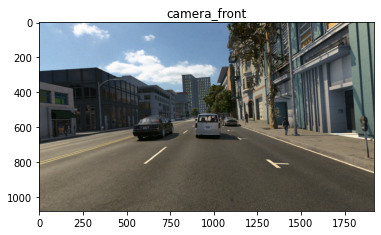

{ 'camera_model': 'opencv_pinhole',
  'cx': 959.5,
  'cy': 539.5,
  'fov': 85,
  'fx': 1047.65625,
  'fy': 1047.65625,
  'k1': 0,
  'k2': 0,
  'k3': 0,
  'k4': 0,
  'k5': 0,
  'k6': 0,
  'p1': 0,
  'p2': 0,
  'skew': 0}


In [20]:
from matplotlib import pyplot as plt
from paralleldomain.model.sensor import Image  # optional import, just for type reference in this tutorial


image_data: Image = camera_0_frame_0.image

print(f"Below is an image with {image_data.channels} channels and resolution {image_data.width}x{image_data.height} sqpx")

plt.imshow(image_data.rgba)  # `.rgba` returns image including alpha-channel, otherwise `.rgb` can be used for convenience.
plt.title(camera_0_frame_0.sensor_name)
plt.show()

pp.pprint(vars(camera_0_frame_0.intrinsic))

### Access LiDAR Data

Similar to a camera, LiDAR sensors have their dedicated sensor frame object `LidarSensorFrame`.
There we can access different point cloud properties like points in Cartesian coordinates, their intensity or timing offsets.

The simple example below creates an orthographic topdown projection of the point cloud in ego-vehicle coordinate system by leveraging the extrinsic information.
The colorization will be done by height, and the size of points will be defined by reflection intensity.

Text(0.5, 1.0, 'lidar_front')

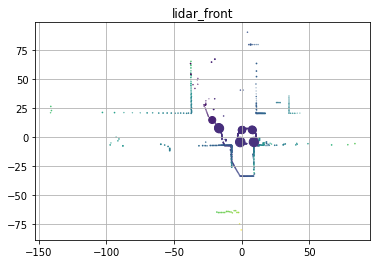

In [21]:
from paralleldomain.model.sensor import PointCloud  # optional import, just for type reference in this tutorial


pc_data: PointCloud = lidar_0_frame_0.point_cloud

pc_xyz_one: np.ndarray = pc_data.xyz_one # Returns the xyz coordinates with an additional column full of "1" to allow for direct transformation
pc_intensity: np.ndarray = pc_data.intensity

pc_ego = (lidar_0_frame_0.extrinsic @ pc_xyz_one.T).T
pc_ego = pc_ego[:,:3]  # throw away "1" - we are done transforming

subset_slice = slice(None, None, 5)  # we want a slice of every 5th point to reduce rendering time

pc_ego_subset = pc_ego[subset_slice]
pc_intensity_subset = pc_intensity[subset_slice]

plt.scatter(x=pc_ego_subset[:,0], y=pc_ego_subset[:,1], s=pc_intensity_subset, c=pc_ego_subset[:,2])
plt.grid(True)
plt.title(lidar_0_frame_0.sensor_name)

In the scatter plot above we can see that the test point cloud is quite sparse (in fact it has only 3 lasers vertically). Nevertheless, outlines of buildings and objects are clearly visible.
Also, there appears to be a couple of highly reflective object in the ego-vehicle's proximity. By applying the LiDAR's extrinsic, we have put (0,0,0) to the ego-vehicle's reference point - here it is the center of the bottom-face.
